# Imports

In [257]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

from keras.utils import to_categorical
from keras.layers import Dense, Activation, Conv2D,Conv2DTranspose, Dropout, Reshape, MaxPooling2D, Flatten
from keras.models import Sequential, load_model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split

# Data importing and pre-processing

In [258]:
df = pd.read_csv('dataset.csv', header=None)


df = df.values.reshape(60, 1,64, 64, 1)

labels = np.zeros(60)

x_real_train, x_real_test = train_test_split(df, test_size=0.2) #12 test values
y_real_train, y_real_test = train_test_split(labels, test_size=0.2)

# Generator Model

Create points in latent space to be fed into generator

In [259]:
def generate_generator_input():
    input = np.random.normal(50,2,size=(1,100))
    input = input * 10
    

    
    return input

In [260]:
def make_generator():
    model = Sequential()
    
    model.add(Dense(60*8*8, input_shape=(100,)))
    model.add(Activation("relu"))
    model.add(Reshape((8,8,60)))
    
    model.add(Conv2DTranspose(1, (1,1), strides=(2,2), padding='same', input_shape=(8,8,60)))
    model.add(Activation("relu"))
  
    
    model.add(Conv2DTranspose(1, (1,1), strides=(2,2), padding='same', input_shape=(16,16,60)))
    model.add(Activation("relu"))

    model.add(Conv2DTranspose(1, (1,1), strides=(2,2), padding='same', input_shape=(32,32,60)))
    model.add(Activation("tanh"))
    
              
    model.summary()
    
    return model
    
    

# Discriminator Model

In [261]:

def make_discriminator():
    
    # 1st set of layers
    model = Sequential()
    model.add(Conv2D(128, (5,5), strides=(2,2), padding="same", input_shape=(64,64,1)))
    model.add(Activation("relu"))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (5,5), strides=(2,2), padding='same'))
    model.add(Activation("relu"))
    model.add(Dropout(0.3))
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
  
    
    # output layer
    model.add(Flatten())
    
    
    
    model.add(Dense(1)) # Binary classification (2 outputs), so only 1 dense layer needed
    
    model.summary()
    return model
    

# Training

First, create the models from the functions

In [262]:
gen_model = make_generator()

noise = generate_generator_input()
test_gen = gen_model(noise, training = False)

print(test_gen)



Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 3840)              387840    
                                                                 
 activation_86 (Activation)  (None, 3840)              0         
                                                                 
 reshape_16 (Reshape)        (None, 8, 8, 60)          0         
                                                                 
 conv2d_transpose_48 (Conv2  (None, 16, 16, 1)         61        
 DTranspose)                                                     
                                                                 
 activation_87 (Activation)  (None, 16, 16, 1)         0         
                                                                 
 conv2d_transpose_49 (Conv2  (None, 32, 32, 1)         2         
 DTranspose)                                         

Next, test the untrained discriminator on the map of noise generated before

Negative values means fake, positive means real

In [263]:
disc_model = make_discriminator()
decision = disc_model(test_gen)
print(decision)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 128)       3328      
                                                                 
 activation_90 (Activation)  (None, 32, 32, 128)       0         
                                                                 
 dropout_22 (Dropout)        (None, 32, 32, 128)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 256)       819456    
                                                                 
 activation_91 (Activation)  (None, 16, 16, 256)       0         
                                                                 
 dropout_23 (Dropout)        (None, 16, 16, 256)       0         
                                                                 
 flatten_11 (Flatten)        (None, 65536)           

## Loss and Optimizers

In [264]:
cross_entropy = BinaryCrossentropy(from_logits=True)

Discriminator loss, adapted from: https://www.tensorflow.org/tutorials/generative/dcgan

In [265]:
def discrim_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator loss

In [266]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Optimizers:

In [267]:
gen_optimizer = Adam(1e-4)
disc_optimizer = Adam(1e-4)

Discriminator accuracy

In [268]:
def compute_discrim_accuracy(real_output, fake_output):
    if real_output >=0:
        
        if fake_output <0:
            accuracy = (real_output + fake_output) / (real_output + fake_output)
        else:
            accuracy = real_output/ (real_output + fake_output)
    elif fake_output <0:
        accuracy = fake_output / (real_output + fake_output)
    else:
        accuracy = 0/ (real_output + fake_output)
    
    return accuracy

## Training

training parameters:

In [269]:
N_EPOCHS = 400

VERBOSE = 1


Training step

In [270]:
@tf.function
def training_step(current_batch):
    
    noise_sample = generate_generator_input()
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_map = gen_model(noise_sample, training=True)
        print("generated map shape" + str(generated_map.shape))
        
        fake_output = disc_model(generated_map,  training=True)
        real_output = disc_model(current_batch, training=True)
        

        gen_loss = generator_loss(fake_output=fake_output)
        disc_loss = discrim_loss(real_output=real_output, fake_output=fake_output)

        disc_accuracy = compute_discrim_accuracy(real_output, fake_output)

        

    gen_gradients = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, disc_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, disc_model.trainable_variables))

    return gen_loss, disc_loss, disc_accuracy

Train models

In [271]:
def train(dataset, N_EPOCHS):

    gen_losses = []
    disc_losses = []

    disc_accuracies = []
    

    for epoch in range(N_EPOCHS):
        gen_losses_for_epoch = []
        disc_losses_for_epoch = []

        print("epoch = " + str(epoch))

        for map_batch in dataset:
            
            map_batch.reshape(1,64,64,1)

            
            gen_loss, disc_loss, disc_accuracy = training_step(map_batch)

            gen_losses_for_epoch.append(gen_loss)
            disc_lossesfor_epoch.append(disc_loss)
            disc_accuracies.append(disc_accuracy)
        
        avg_disc_loss = 
    
    input_for_map_after_training = generate_generator_input()
    generated_map = gen_model(input_for_map_after_training, training=False)

    print(generated_map)

    return gen_losses, disc_losses, generated_map


Train GAN

In [272]:
print(x_real_train.shape)

gen_losses, disc_losses, generated_map = train(x_real_train, N_EPOCHS)

# issue with flattening in discrim, flatten is not flattening for the final dense layer. I don't know why this is the case.

#write generated map to csv

with open('generated_map.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    for i in range(64):
        writer.writerow(generated_map[0][i])


(48, 1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
generated map shape(1, 64, 64, 1)
generated map shape(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
shape of current map(1, 64, 64, 1)
sha

graphs:

ValueError: x and y must have same first dimension, but have shapes (19200,) and (1, 400)

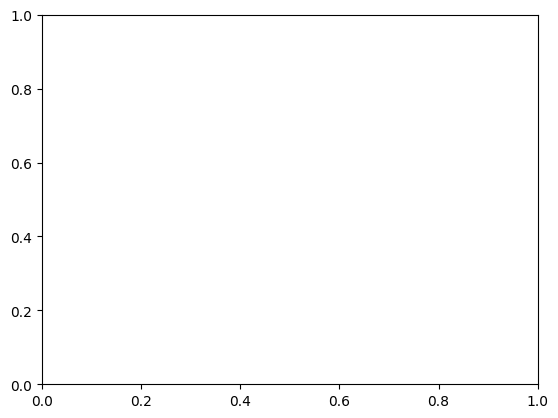

In [273]:
epoch_list = [range(0,N_EPOCHS)]
plt.plot(disc_losses, epoch_list, 'r-')
plt.plot(gen_losses, epoch_list, 'b-')
plt.title('Gen and Disc loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')